# Baseline Model #1

## Predict Sea Surface Temperature (WTMP) using SARIMA Model

# Reaadings / Tutorials:

* https://towardsdatascience.com/weather-forecasting-with-machine-learning-using-python-55e90c346647
* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
* https://www.youtube.com/watch?v=8yzVWoivCF4

In [19]:
import pandas as pd
import missingno as msno
import myLibrary as mL

from pmdarima import auto_arima
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [20]:
## Figure out which station in the GOM is the best to use:

#stations = mL.stations_GOM
#NaN_statistic = pd.DataFrame()

#for stationID in mL.cleaned_stations_GOM:
#    data = mL.get_buoy_data(stationID, "2022")
#    if data is not None:
#        num_values, num_NaN_percentage, NaN_by_feature = mL.print_NaN_statistic(data, "", silent=True)
#        new_row = pd.DataFrame({
#            "StationID": [stationID],
#            "#NaN in %": [num_NaN_percentage]
#        })
#        NaN_statistic = pd.concat([NaN_statistic, new_row])

#NaN_statistic

In [21]:
STATION_ID = "42036"    # 33.61% NaN values -> Best value for GOM and 2022
YEAR = "2022"   #Because I want it to be as up-to-date as possible to test if additional years improve the performance.

In [22]:
data = mL.get_buoy_data(STATION_ID, YEAR)
data

,WDIR_42036,WSPD_42036,WVHT_42036,APD_42036,MWD_42036,PRES_42036,ATMP_42036,WTMP_42036,DEWP_42036
timestamp,,,,,,,,,
2022-01-01 00:00:00,168.0,3.5,NaN,NaN,NaN,1016.3,23.3,23.0,23.3
2022-01-01 01:00:00,166.0,4.5,NaN,NaN,NaN,1016.6,23.2,23.0,23.2
2022-01-01 02:00:00,171.0,5.4,NaN,NaN,NaN,1017.0,23.2,23.0,23.2
2022-01-01 03:00:00,170.0,5.2,NaN,NaN,NaN,1017.1,23.2,23.0,23.2
2022-01-01 04:00:00,169.0,5.7,NaN,NaN,NaN,1017.1,23.2,23.0,23.2
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,147.0,7.9,NaN,NaN,NaN,1016.2,21.3,22.0,20.9
2022-12-31 20:00:00,164.0,6.1,NaN,NaN,NaN,1016.1,21.5,22.0,21.2
2022-12-31 21:00:00,187.0,4.9,NaN,NaN,NaN,1016.6,22.2,22.1,21.4


In [23]:
data = data.drop([
    "WDIR_42036",
    "WSPD_42036",
    "WVHT_42036",
    "APD_42036",
    "MWD_42036",
    "PRES_42036",
    "ATMP_42036",
    #"WTMP_42036",
    "DEWP_42036"], axis=1)

data

,WTMP_42036
timestamp,
2022-01-01 00:00:00,23.0
2022-01-01 01:00:00,23.0
2022-01-01 02:00:00,23.0
2022-01-01 03:00:00,23.0
2022-01-01 04:00:00,23.0
...,...
2022-12-31 19:00:00,22.0
2022-12-31 20:00:00,22.0
2022-12-31 21:00:00,22.1


In [26]:
print("NaN values: ", data.isna().sum().sum())
# msno.matrix(data)

Remaining NaN values:  0


In [27]:
data.fillna(method='ffill', inplace=True) #ffill .. forward fill (just copy previous value)
print("Remaining NaN values: ", data.isna().sum().sum())
# msno.matrix(data)

Remaining NaN values:  0


<AxesSubplot:xlabel='timestamp'>

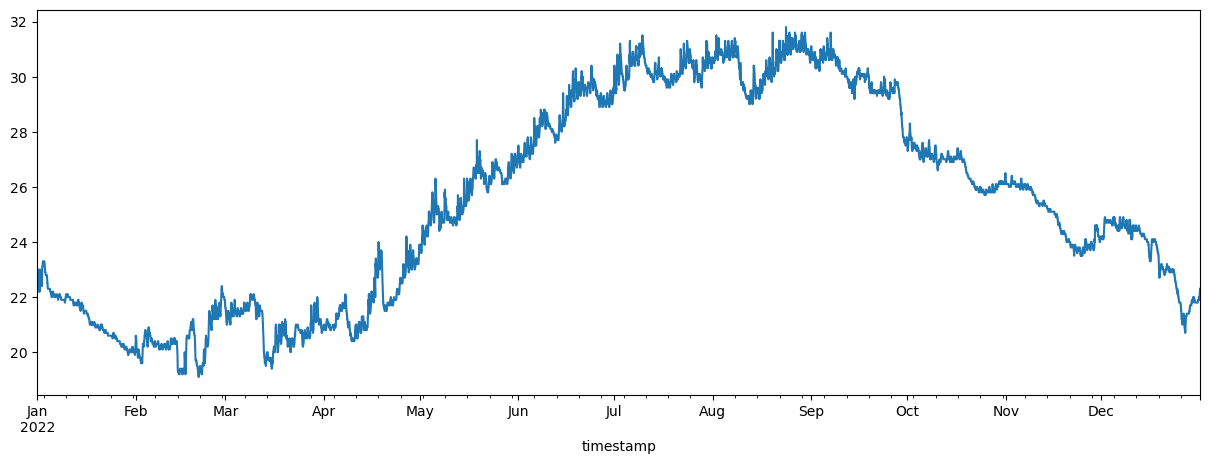

In [28]:
data["WTMP_42036"].plot(figsize=(15,5))

## Train / Test Split

In [29]:
test_hours = 7*24 #one week forecast

# split the dataframe into training and testing subsets
train = data.iloc[: -test_hours,:]
test = data.iloc[-test_hours:, :]

In [30]:
train

,WTMP_42036
timestamp,
2022-01-01 00:00:00,23.0
2022-01-01 01:00:00,23.0
2022-01-01 02:00:00,23.0
2022-01-01 03:00:00,23.0
2022-01-01 04:00:00,23.0
...,...
2022-12-24 19:00:00,22.2
2022-12-24 20:00:00,22.3
2022-12-24 21:00:00,22.2


In [31]:
test

,WTMP_42036
timestamp,
2022-12-25 00:00:00,22.2
2022-12-25 01:00:00,22.2
2022-12-25 02:00:00,22.1
2022-12-25 03:00:00,22.1
2022-12-25 04:00:00,22.0
...,...
2022-12-31 19:00:00,22.0
2022-12-31 20:00:00,22.0
2022-12-31 21:00:00,22.1


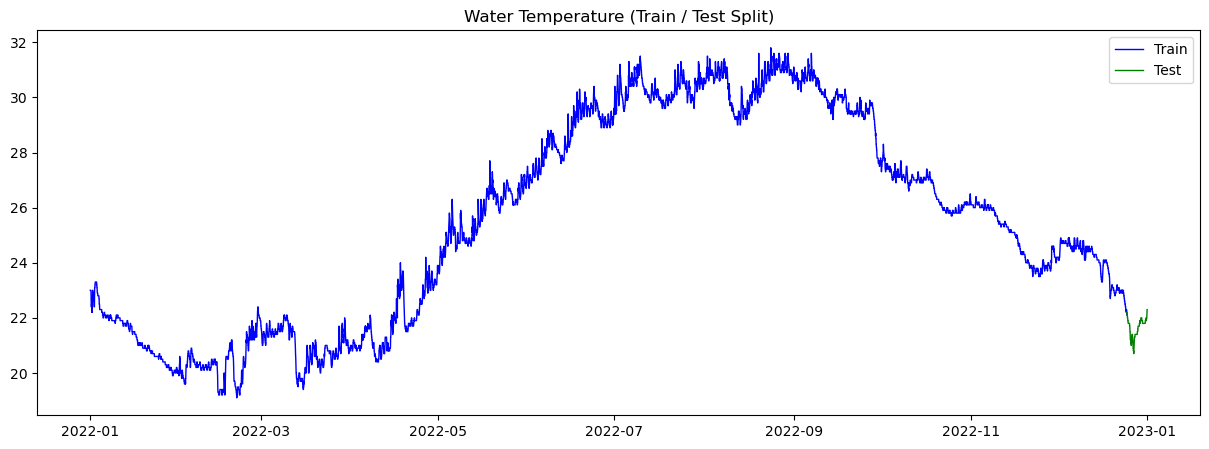

In [32]:
# create a figure and axes objects with figsize
fig, ax = plt.subplots(figsize=(15, 5))

# plot the train and test data
ax.plot(train.index, train['WTMP_42036'], color='blue', label='Train', lw=1)
ax.plot(test.index, test['WTMP_42036'], color='green', label='Test', lw = 1)

# add heading and legend to the chart
ax.set_title('Water Temperature (Train / Test Split)')
ax.legend()

# display the chart
plt.show()

In [33]:
model = auto_arima(y=train.WTMP_42036,
                   m= 24    #Seasonal component (daily)
                   )

In [34]:
predictions = pd.Series(model.predict(n_periods = len(test)))
predictions.index = test.index
predictions

timestamp
2022-12-25 00:00:00    22.100000
2022-12-25 01:00:00    22.089727
2022-12-25 02:00:00    22.089727
2022-12-25 03:00:00    22.089727
2022-12-25 04:00:00    22.079454
                         ...    
2022-12-31 19:00:00    21.894709
2022-12-31 20:00:00    21.894764
2022-12-31 21:00:00    21.894709
2022-12-31 22:00:00    21.894691
2022-12-31 23:00:00    21.894636
Length: 168, dtype: float64

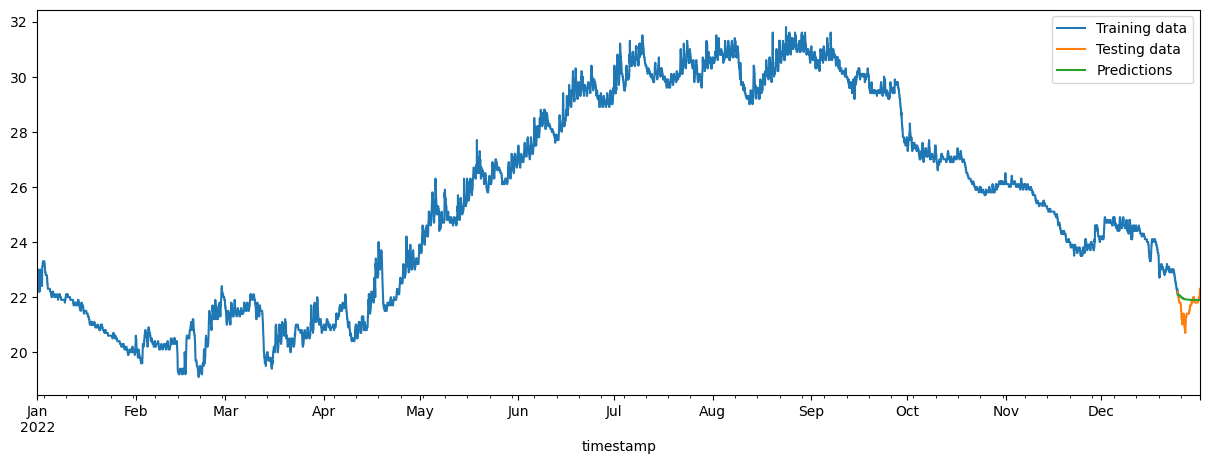

In [35]:
train['WTMP_42036'].plot(figsize = (15,5), label = 'Training data')
test['WTMP_42036'].plot(label = 'Testing data')
predictions.plot(label = 'Predictions')
plt.legend()

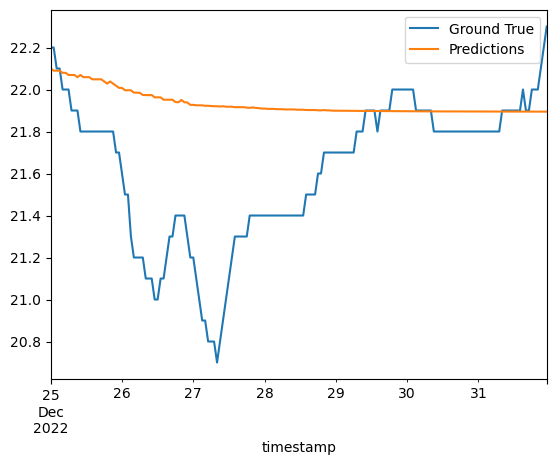

In [36]:
test['WTMP_42036'].plot(label = 'Ground True')
predictions.plot(label = 'Predictions')
plt.legend()

In [37]:
test["WTMP_42036_prediction"] = predictions
test

/var/folders/ys/lj6w647n5qjdv23zdxs_fn740000gn/T/ipykernel_14690/3717574519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["WTMP_42036_prediction"] = predictions


,WTMP_42036,WTMP_42036_prediction
timestamp,,
2022-12-25 00:00:00,22.2,22.100000
2022-12-25 01:00:00,22.2,22.089727
2022-12-25 02:00:00,22.1,22.089727
2022-12-25 03:00:00,22.1,22.089727
2022-12-25 04:00:00,22.0,22.079454
...,...,...
2022-12-31 19:00:00,22.0,21.894709
2022-12-31 20:00:00,22.0,21.894764
2022-12-31 21:00:00,22.1,21.894709


In [38]:
mae = mean_absolute_error(test["WTMP_42036"], test["WTMP_42036_prediction"])
mse = mean_squared_error(test["WTMP_42036"], test["WTMP_42036_prediction"])

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)

Mean Absolute Error:  0.34106243459144897
Mean Squared Error:  0.21585821241299014


# Baseline Model 1:

Dataset:
Only one buoy: 42036
Time: one year (2022)
Features: Only consider single feature (in that case WTMP)

Preprocessing:
* (Merge time related columns to one timestamp)
* Replace 9999 etc. with NaN
* Filter by 1h timestamps (not sure if this changed anything ... ) + added raw if no value available!
* NaN imputation: forward fill ... it basically uses the previous value and copies it.

Train / Test Split: predict last week of this year.

Result:
See chart above
MAE: 0.34°C
MSE: 20%


